# 💡 Build and evaluate a zero-shot sentiment classifier with GPT-3

In this tutorial, we'll **build and evaluate a sentiment classifier for customer requests in the financial domain** using GPT-3 and Argilla. 

GPT-3 is a powerful [model and API](https://openai.com/api/) from OpenAI that performs a variety of natural language tasks. [Argilla](https://www.argilla.io/) empowers you to quickly build and iterate on data for NLP.

In this tutorial, you'll learn to:

- Set up and use a zero-shot sentiment classifier, which not only analyses the sentiment but also includes an explanation of its predictions!
- Use Argilla to evaluate the quality of predictions and review an existing training set.

This tutorial highlights the potential of building human-in-the-loop workflows involving large language models like GPT-3. 

Let's get started!

![Screenshot of Argilla UI](../../_static/tutorials/labelling-textclassification-gpt3-fewshot/labelling-textclassification-gpt3-fewshot-1.png)

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.ipynb). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

## Setup
In this tutorial, we'll use `openai` and `datasets` libraries.

In [ ]:
%pip install openai datasets argilla -qqq

Let's import the Argilla module for reading and writing data:

In [ ]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="http://localhost:6900", 
    api_key="admin.apikey"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

Now let's include the imports we need:

In [174]:
import os
from json import loads
import openai
from datasets import load_dataset
import pandas as pd
from argilla.metrics.text_classification import f1
from argilla.metrics.commons import text_length

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## 0. The dataset: `banking77` sentiment dataset

For this tutorial, we'll use a small dataset that contains labels created with Argilla as part of [other tutorials](training-textclassification-transformers-pretrained.ipynb).

This dataset is based on the [banking77](https://huggingface.co/datasets/banking77) dataset, which contains online banking user queries annotated with their corresponding intents. 

For our use case, **we've labelled the sentiment of these queries** which might be useful for digital assistants and customer service analytics.


Let's load the labelled dataset directly from the Hub.

In [5]:
banking_ds = load_dataset("argilla/banking_sentiment_setfit")
# preview dataset content
banking_ds["train"].to_pandas().head(15)

,text,label
0,are you sending me my card?,1
1,Two days ago I did a transfer to another accou...,1
2,Why didn't I receive the right amount of cash?,0
3,Is there a reason why my virtual card won't work?,0
4,Why is my balance the same after a transfer?,1
5,My money hasn't been transferred yet.,0
6,"It is still pending, I am still waiting. Your ...",0
7,What are the places that you deliver cards to?,1
8,Why are my withdrawals suddenly being declined?,1
9,How do I reset my passcode?,1


### A note on sentiment analysis and data annotation

Sentiment analysis is one of the most subjective tasks in NLP. What we understand by sentiment will vary from one application to another and depend on the business objectives of the project. Also, sentiment can be modeled in different ways, leading to different **labeling schemes**. 

For example, sentiment can be modeled as real value (going from -1 to 1, from 0 to 1.0, etc.) or with 2 or more labels (including different degrees such as positive, negative, neutral, etc.)

For this tutorial, we'll use the **following labeling scheme**: `POSITIVE`, `NEGATIVE` and `NEUTRAL`.

## 1. Building a zero-shot sentiment classifier with GPT-3

In order to build a zero-shot sentiment classifier we need to design a prompt, a technique known as "Prompt Engineering". For this tutorial, we've experimented with several prompts using the OpenAI playground, and inspired by the [excellent blog](https://medium.com/@xmikex83/building-an-aspect-based-sentiment-analysis-pipeline-using-gpt-3-67e26f2a8a5b) post by [Michele Pangrazzi](https://medium.com/@xmikex83).

We'll be using the [Completion API](https://beta.openai.com/docs/api-reference/completions/create), you can check the reference documentation to understand the different function parameters.

To find the prompt template, we've played with different variations using the OpenAI playground UI, as shown below:

![Screenshot of Argilla UI](../../_static/tutorials/labelling-textclassification-gpt3-fewshot/labelling-textclassification-gpt3-fewshot-2.png)

The main structure of our prompt is:

1. **Define the task**: sentiment classification of customer requests
2. **Define the format and labels**: we want three labels and a JSON format (so far this format only worked for `text-davinci-003` the most recent and powerful model)
3. **Define the text to classify**: this part we'll be added for each example in our dataset.

Probably the most interesting thing of this prompt is that **we ask the model to explain its prediction and add it to the response**. You'll see later that this is a powerful mechanism to understand the model decisions, the task, and even review our manually labelled ground-truth.

As we want to test zero-shot capabilities we won't provide any examples. In further tutorials, we'll extend this with N-shot by providing examples in the prompt itself, and also show how you can fine-tune GPT-3 with labelled examples. If you are interested join our [amazing community](http://hf.co/join/discord) and let's discuss!

Below we define the prompt template, to which we will append the text to classify before calling the `openai.Completion.create` function.

In [161]:
PROMPT_TEMPLATE = """
Classify the sentiment of the customer request using the following JSON format. Use positive, negative, and neutral in lowercase:

{"prediction": sentiment label string, "explanation": sentence string describing why you think is the sentiment}

Customer request:

"""

Now, let's define our classification function. This function adds the input text to the prompt template, calls the OpenAI API, and tries to parse the JSON response. In some of our experiments, sometimes the returned JSON is not valid. We take this into account and flag those predictions as `None` and add the json response in the explanation field. 


<div class="alert alert-info">

Note

If you want to skip the prediction calls to OpenAI, you can load the records with the predictions and labels from the Hugging Face Hub by running the code below and going directly to step 2:
    
```python

records = load_dataset("argilla/banking_sentiment_zs_gpt3", split="train")
rg.log(records, "banking_sentiment_zs_gpt3")
    
```
    
</div>

In [162]:
# set your api key as ENV, for example with Python: os.environ["OPENAI_API_KEY"]
openai.api_key = os.getenv("OPENAI_API_KEY") 

def classify(text):
    # build prompt with template and input
    prompt = f"{PROMPT_TEMPLATE}\n{text}\n"
    # use create completion template
    completion = openai.Completion.create(
      model="text-davinci-003",
      prompt=prompt,
      temperature=0,
      max_tokens=256
    )
    # get first choice text
    json_response = completion["choices"][0]["text"].strip()
    try:
        prediction = loads(json_response)
    except:
        # for some examples, json is not correctly formatted
        return {"prediction": None, "explanation": f"Wrong JSON format: {json_response}" }
    return prediction  

Now let's call this method for each example in our banking sentiment test set so we can compare it with other methods (SetFit, Few-shot GPT-3, and others).

We use the `map` method from the `datasets` library and show the results in a table as follows:

In [190]:
# let's predict over the test set to eval our zero-shot classifier
test_ds_with_preds = banking_ds["test"].map(lambda example: classify(example["text"]))

pd.set_option('display.max_colwidth', None)
test_ds_with_preds.to_pandas().head(15)

,text,label,prediction,explanation
0,My card payment had the wrong exchange rate,0,negative,"The customer is expressing dissatisfaction with their card payment having the wrong exchange rate, indicating a negative sentiment."
1,I believe that a card payment I made was cancelled.,1,neutral,"The customer is expressing a belief, but not expressing any sentiment about the situation."
2,Why was I charged for getting cash?,1,negative,"The customer is expressing frustration and confusion about being charged for getting cash, indicating a negative sentiment."
3,"I deposited cash into my account a week ago and it is still not available, please tell me why? I need the cash back now.",0,negative,"The customer is expressing frustration and urgency due to the delay in their cash being available, indicating a negative sentiment."
4,Do you accept cash?,1,neutral,The customer is simply asking a question and does not express any sentiment.
5,Is the top-up amount unlimited?,1,neutral,"The customer is asking a factual question, not expressing an opinion or emotion."
6,I think I am a victim of fraud. I noticed there was a charge on my account that I didn't do because I haven't touched my card today. Can you please reverse the charge and refund my money?,0,negative,"The customer is expressing concern about a fraudulent charge on their account, indicating a negative sentiment."
7,Why do I see an extra €1 charge on my statement?,0,neutral,The customer is asking a question without expressing any sentiment.
8,I tried to transfer money to a receiver and they didn't get the right amount. What is going on and who do I contact to help me?,0,negative,"The customer is expressing frustration with an issue that has not been resolved, indicating a negative sentiment."
9,The check I deposited yesterday isn't listed yet. Isn't that pretty slow? I need to see the balance increased by that check.,0,negative,"The customer is expressing frustration with the slow processing of their check deposit, indicating a negative sentiment."


## 2. Evaluating our zero-shot sentiment classifier

Now we have our small test dataset with predictions from GPT-3 zero-shot classifier. It's time to use Argilla to evaluate our model.

First, we'll build the dataset and log it into Argilla using the `rg.log` method. We'll include the `explanation` as part of the input so we can quickly see both the prediction and their explanation:

In [ ]:
import argilla as rg

# get the label strings to turn int ids into string names
labels = banking_ds["test"].features["label"].names

records = []
for example in test_ds_with_preds:
    # create a record with ground-truth annotations and gpt-3 predictions
    record = rg.TextClassificationRecord(
        inputs={"text": example["text"], "explanation": example["explanation"]},
        annotation=labels[example["label"]],
        prediction=[(example["prediction"].lower(), 1.0)]
    )
    records.append(record)

# create a dataset in Argilla
rg.log(records, "banking_sentiment_zs_gpt3")

This will take 1 second and create a fully browsable dataset in the Argilla UI. Let's now analyze the quality of GPT-3's predictions.

### Overall metrics

Using the `metrics` module we can get a quick overview of the overall performance metrics as follows. The model achieves around `0.77` F1 micro-average.


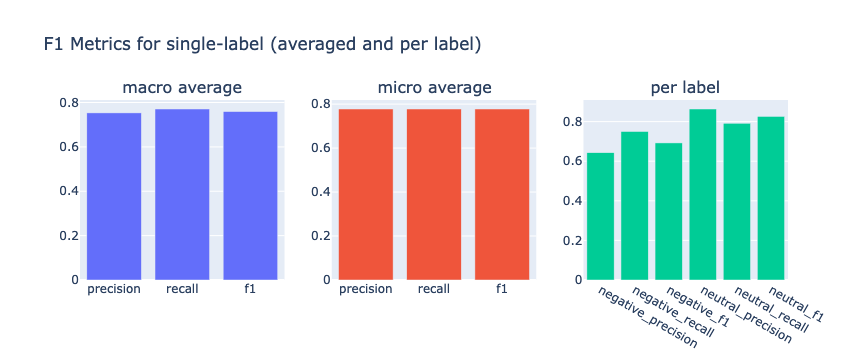

In [180]:
f1("banking_sentiment_zs_gpt3").visualize()

Another interesting metric is the distribution by input text length:

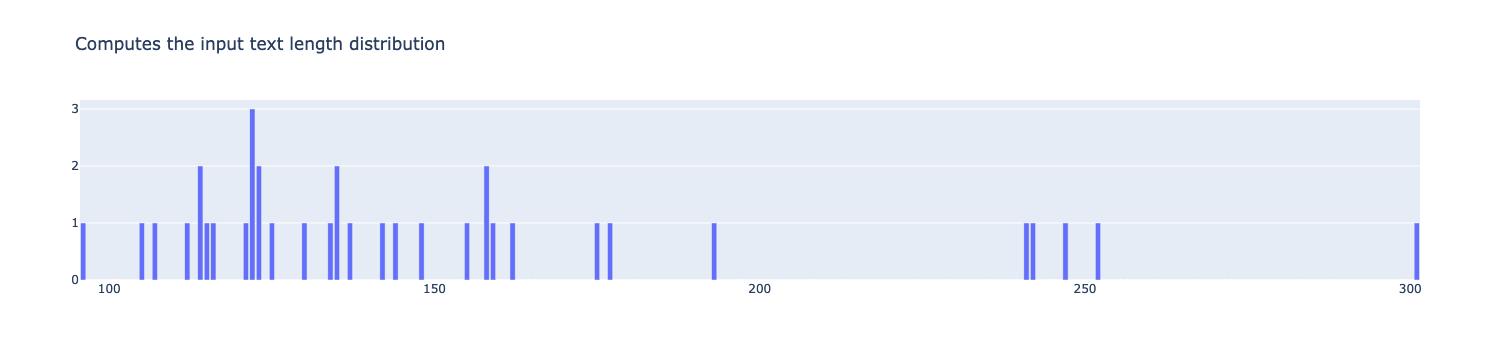

In [181]:
text_length("banking_sentiment_zs_gpt3").visualize()

Using ES query string DSL, we can compute performance metrics by interesting regions in the dataset. For example, we can see that performance for longer text (> 175) and neutral examples is much lower than for shorter text (<175). 

Note that this is a really small dataset, but with a larger dataset we could analyze if our model struggles with longer text, or if longer texts tend to be negative, for example.

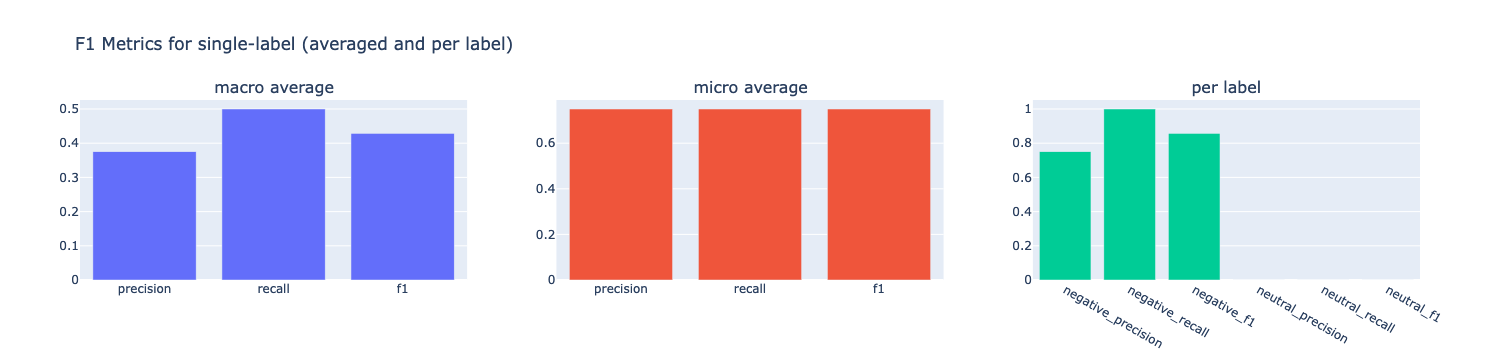

In [187]:
f1("banking_sentiment_zs_gpt3", query="metrics.text_length:[175 TO *]").visualize()

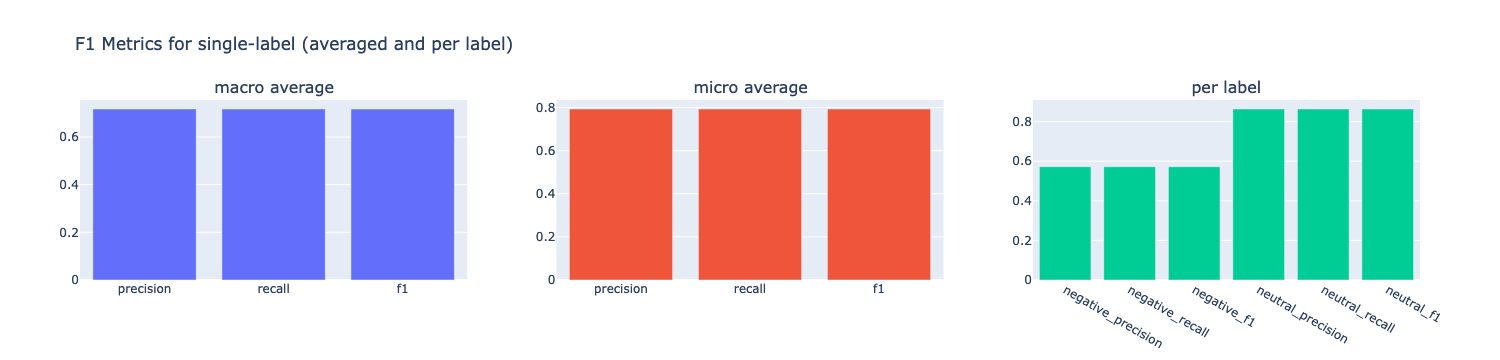

In [188]:
f1("banking_sentiment_zs_gpt3", query="metrics.text_length:[* TO 175]").visualize()

### Fine-grained analysis

Now let's use Argilla UI to perform a fine-grained analysis of "incorrect" predictions. You can easily do this using the `predicted` filter as shown below:

![Screenshot of Argilla UI](../../_static/tutorials/labelling-textclassification-gpt3-fewshot/labelling-textclassification-gpt3-fewshot-1.png)

This filter we'll show you exemplifies where the ground-truth disagrees with GPT-3. It will also show you the explanation behind GPT-3's prediction. Looking at some examples, such as the one shown below, we find that some labels in the ground-truth could be wrong or at least ambiguous. For other examples, GPT-3 could be better instructed with examples or by refining the prompt.

![Screenshot of Argilla UI](../../_static/tutorials/labelling-textclassification-gpt3-fewshot/labelling-textclassification-gpt3-fewshot-3.png)


This highlights the potential of building human-in-the-loop workflows on top of services using large language models like GPT-3.
